ECS 171 Final Project\
Rent Prediction Machine Learning Model\
Group 20\
Lucas Flansburgh, Max Lin, Sriram Pinnapureddy, Amritpal Zenda

Packages and Functions

In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

Original Data Preprocessing

In [2]:
# read in data
apartments = pd.read_csv('apartments_for_rent_classified_10K.csv')

# view data structure
print(apartments.head())
print(apartments.shape)

# checking distribution of various features
print(apartments['currency'].value_counts())
print(apartments['price_type'].value_counts())
print(apartments['fee'].value_counts())

# Filter for only apartments where the price type is monthly
apartments = apartments[apartments['price_type'] == "Monthly"]

# drop columns that will not be useful
apartments = apartments.drop(columns=['currency', 'price_display', 'id', 'Unnamed: 0', 'fee', 'price_type'])

# converting bedrooms and square footage to floats since they came in as categorical
apartments['bedrooms'] = apartments['bedrooms'].astype(float)
apartments['square_feet'] = apartments['square_feet'].astype(float)

# viewing more distributions
print(apartments['bathrooms'].value_counts())
print(apartments['has_photo'].value_counts())

# dropping all rows with any na values
apartments = apartments.dropna(axis = 0)

# view data after first round of preprocessing
print(apartments.shape)
print(apartments)

   Unnamed: 0          id  bathrooms  bedrooms currency fee  has_photo  \
0           1  5668626895        NaN       0.0      USD  No  Thumbnail   
1           2  5664597177        NaN       1.0      USD  No  Thumbnail   
2           3  5668626833        1.0       0.0      USD  No  Thumbnail   
3           4  5659918074        1.0       0.0      USD  No  Thumbnail   
4           5  5668626759        NaN       0.0      USD  No  Thumbnail   

  pets_allowed  price price_display price_type  square_feet    cityname state  
0          NaN    790          $790    Monthly          101  Washington    DC  
1          NaN    425          $425    Monthly          106  Evansville    IN  
2          NaN   1390        $1,390    Monthly          107   Arlington    VA  
3          NaN    925          $925    Monthly          116     Seattle    WA  
4          NaN    880          $880    Monthly          125   Arlington    VA  
(10000, 14)
currency
USD    10000
Name: count, dtype: int64
price_type
Mont

Exploratory Data Analysis

Axes(0.125,0.11;0.62x0.77)


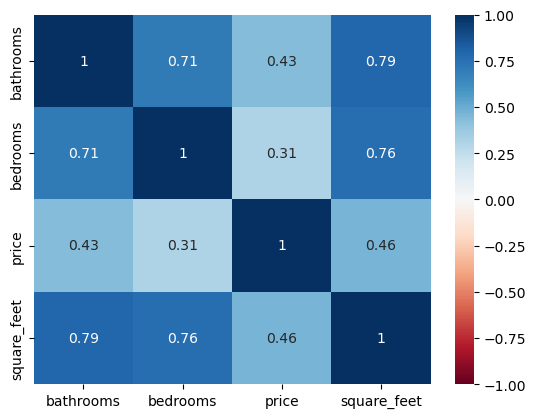

In [3]:
# copy of apartments without categorical variables
apartment_corr = apartments.copy().drop(columns = ['has_photo', 'pets_allowed', 'state', 'cityname']).corr()

# creating a visualization by using a correlation matrix with the color range being [-1,1] and center being 0
pcmp = sns.heatmap(apartment_corr, vmin=-1, vmax=1, center=0, annot=True, cmap= 'RdBu')

print(pcmp)

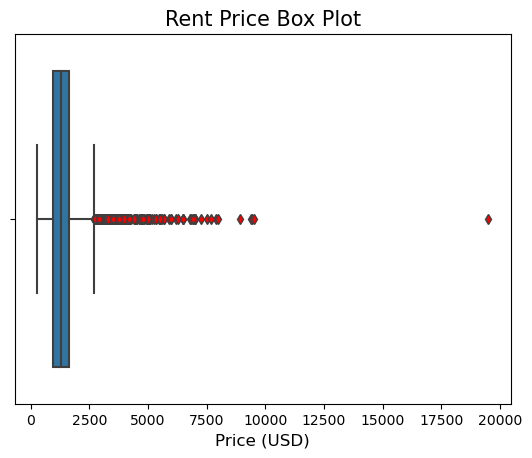

In [4]:
# boxplot of response our variable, price
sns.boxplot(x = apartments['price'], flierprops = {"markerfacecolor": "red"})
plt.title('Rent Price Box Plot', fontsize=15)
plt.xlabel('Price (USD)', fontsize=12)
plt.show()

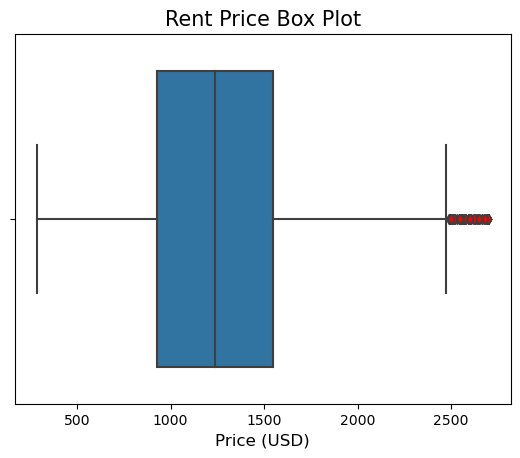

In [5]:
# filtering out ourliers based on 1.5*IQR
apartments = apartments[apartments['price'] < 2700]

# reprinting boxplot without outliers
sns.boxplot(x = apartments['price'], flierprops = {"markerfacecolor": "red"})
plt.title('Rent Price Box Plot', fontsize=15)
plt.xlabel('Price (USD)', fontsize=12)
plt.show()

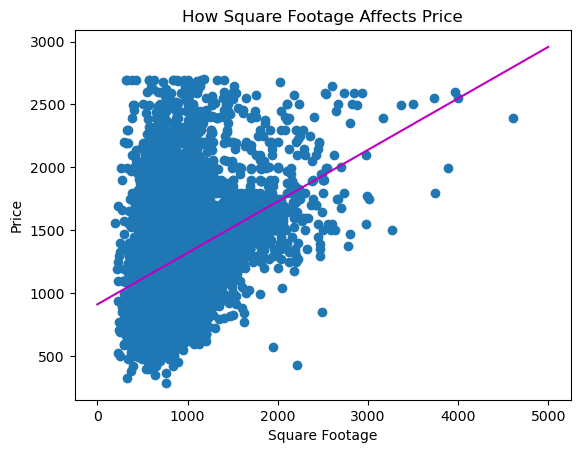

In [6]:
# create a model for square_footage vs. price
price_sqft = np.poly1d(np.polyfit(apartments['square_feet'], apartments['price'], 1))

# create scatter plot
myline = np.linspace(0, 5000)
plt.scatter(apartments['square_feet'], apartments['price'])
plt.title("How Square Footage Affects Price")
plt.plot(myline, price_sqft(myline), color = 'm')
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.show()

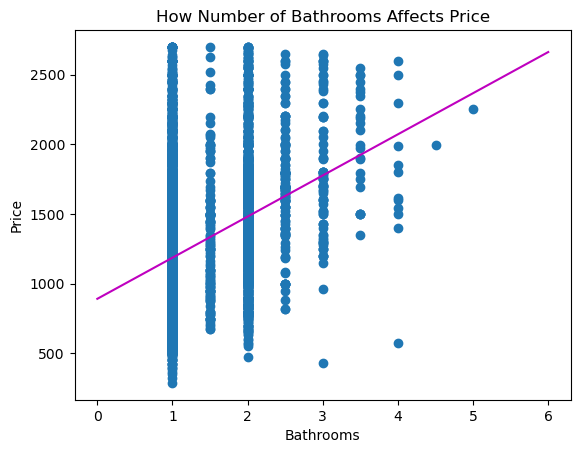

In [7]:
# create a model for square_footage vs. price
price_bathrooms = np.poly1d(np.polyfit(apartments['bathrooms'], apartments['price'], 1))

# create scatter plot
myline = np.linspace(0, 6)
plt.scatter(apartments['bathrooms'], apartments['price'])
plt.title("How Number of Bathrooms Affects Price")
plt.xlabel("Bathrooms")
plt.ylabel("Price")
plt.plot(myline, price_bathrooms(myline), color = 'm')
plt.show()

<Axes: title={'center': 'Average Rent Price Among States'}, xlabel='State', ylabel='Price'>

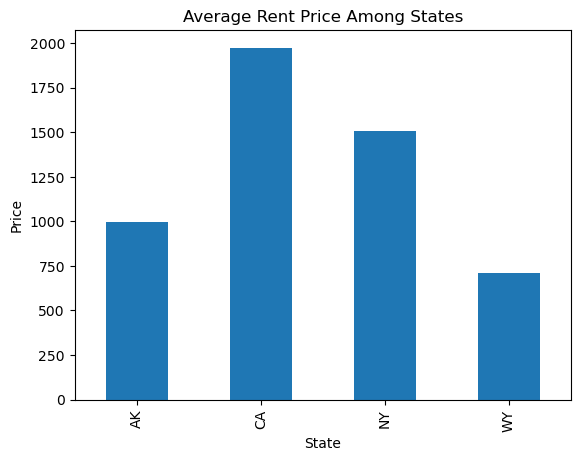

In [8]:
# get some states that we predict to have very different average prices
ex_states = ['CA', 'NY', 'WY', 'AK']

# filter the dataset for only these apartments
ca_ny_wy_ak = apartments[(apartments['state'] == 'CA') | (apartments['state'] == 'NY') | (apartments['state'] == 'WY') | (apartments['state'] == 'AK')]

# group by state and create barplot of the mean for each
ca_ny_wy_ak.groupby('state').agg('price').mean().plot(kind='bar', xlabel='State', ylabel='Price', title = "Average Rent Price Among States")

1654.4489795918366
1218.2244444444445
pets_allowed
Cats,Dogs    4847
Cats          450
Dogs           98
Name: count, dtype: int64


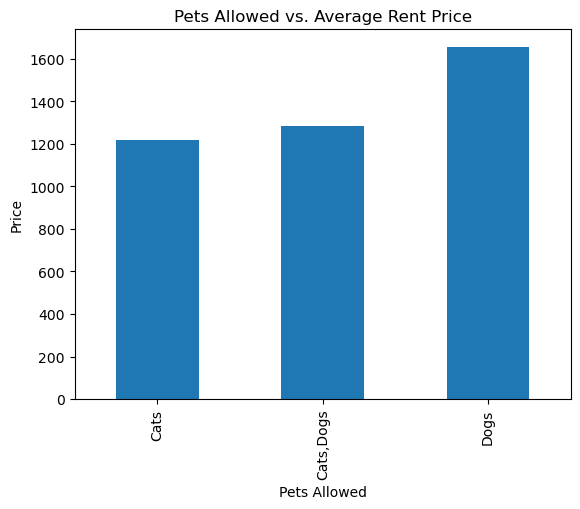

In [9]:
# create barplot for average price among different pets allowed
apartments.groupby('pets_allowed').agg('price').mean().plot(kind='bar', xlabel='Pets Allowed', ylabel='Price', title = "Pets Allowed vs. Average Rent Price")

# double checking results because we found them to be odd
dogs = apartments[apartments['pets_allowed'] == 'Dogs']
print(dogs['price'].mean())
cats = apartments[apartments['pets_allowed'] == 'Cats']
print(cats['price'].mean())

# getting values for each category - noting the imbalance
print(apartments['pets_allowed'].value_counts())

has_photo
Thumbnail    4987
Yes           348
No             60
Name: count, dtype: int64


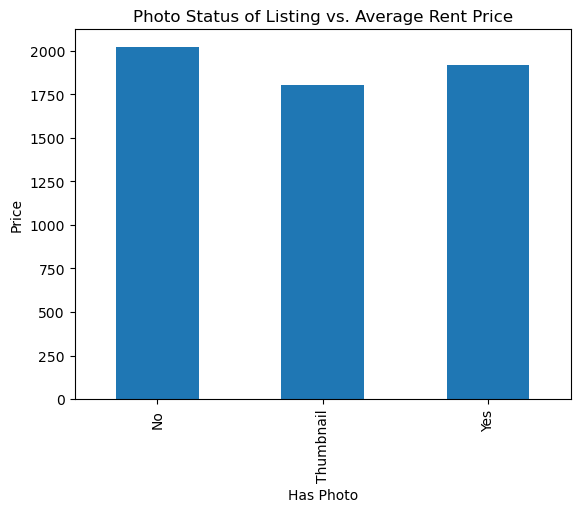

In [10]:
# creating boxplot of average phot status pricings
ca_ny_wy_ak.groupby('has_photo').agg('price').mean().plot(kind='bar', xlabel='Has Photo', ylabel='Price', title = "Photo Status of Listing vs. Average Rent Price")

# getting values for each category - noting the imbalance
print(apartments['has_photo'].value_counts())

In [11]:
# getting values for each category - noting the imbalance
print(apartments['cityname'].value_counts())

# get counts of the total cities
cityname_counts = apartments['cityname'].value_counts()

# filter for big cities only to prevent overfitting
big_cities = cityname_counts[cityname_counts > 30].index

print(big_cities)

# get the filtered data frame
filtered_df = apartments[apartments['cityname'].isin(big_cities)]

# check shape to see that we still have suficient data
filtered_df.shape                           
                            

cityname
Houston          163
Dallas           147
Austin           140
Chicago          114
Kansas City       81
                ... 
Hammond            1
Gonzales           1
Andover            1
Roselle Park       1
Saint Leonard      1
Name: count, Length: 1154, dtype: int64
Index(['Houston', 'Dallas', 'Austin', 'Chicago', 'Kansas City', 'Portland',
       'Madison', 'Omaha', 'Los Angeles', 'San Antonio', 'Cincinnati',
       'Minneapolis', 'Seattle', 'Denver', 'Arlington', 'Milwaukee',
       'Colorado Springs', 'Raleigh', 'Phoenix', 'Saint Louis', 'Atlanta',
       'Marietta', 'Charlotte', 'Springfield', 'Philadelphia', 'Washington',
       'Sioux Falls', 'Columbia', 'Las Vegas', 'Tampa', 'Euless', 'Anchorage',
       'Oklahoma City'],
      dtype='object', name='cityname')


(1925, 8)

Back to normal

Further Data Preprocessing and Multiple Linear Regression Model 1

In [12]:
# get a copy of the dataset for one-hot-encoding
apartments_mlr = filtered_df.copy()

# one-hot-encode state variables
one_hot_encoded = pd.get_dummies(apartments_mlr['state'])
# Concatenate apartments with the one-hot encoded variables
one_hot_encoded = one_hot_encoded.astype('int')
apartments_mlr = pd.concat([apartments_mlr, one_hot_encoded], axis=1).drop('state', axis = 1)
print(apartments_mlr)

# one-hot-encode cityname variables
one_hot_encoded = pd.get_dummies(apartments_mlr['cityname'])
# Concatenate apartments with the one-hot encoded variables
one_hot_encoded = one_hot_encoded.astype('int')
apartments_mlr = pd.concat([apartments_mlr, one_hot_encoded], axis=1).drop('cityname', axis = 1)
print(apartments_mlr)

# one-hot-encode has_photo variables
one_hot_encoded = pd.get_dummies(apartments_mlr['has_photo'])
# Concatenate apartments with the one-hot encoded variables
one_hot_encoded = one_hot_encoded.astype('int')
apartments_mlr = pd.concat([apartments_mlr, one_hot_encoded], axis=1).drop('has_photo', axis = 1)

# one-hot-encode pets_allowed variables
one_hot_encoded = pd.get_dummies(apartments_mlr['pets_allowed'])
# Concatenate apartments with the one-hot encoded variables
one_hot_encoded = one_hot_encoded.astype('int')
apartments_mlr = pd.concat([apartments_mlr, one_hot_encoded], axis=1).drop('pets_allowed', axis = 1)

# save a copy of processed data for decision tree model
apartments_dt = apartments_mlr.copy()

train, test = train_test_split(apartments_mlr, test_size=0.2, random_state=10)

# splitting up the predictor and prediction variables for both the training and testing data
X_train, y_train = train.drop(columns=['price']), train['price']
X_test, y_test = test.drop(columns=['price']), test['price']

# Initialize LinearRegression model
model1 = LinearRegression()

# Fit the model to the training data
model1.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model1.predict(X_test)
y_pred_train = model1.predict(X_train)

# Evaluate the model
mse_test = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error Test:", mse_test)
print("Mean Squared Error Train:", mse_train)
print("r2 score: ", r2)

      bathrooms  bedrooms  has_photo pets_allowed  price  square_feet  \
38          1.0       0.0  Thumbnail    Cats,Dogs   1195        223.0   
40          1.0       1.0  Thumbnail         Cats    942        225.0   
41          1.0       0.0  Thumbnail    Cats,Dogs   1250        228.0   
45          1.0       0.0  Thumbnail         Cats   1095        231.0   
49          1.0       0.0  Thumbnail    Cats,Dogs   1299        243.0   
...         ...       ...        ...          ...    ...          ...   
9846        2.5       4.0  Thumbnail    Cats,Dogs   2445       2648.0   
9859        2.5       4.0  Thumbnail    Cats,Dogs   2000       2700.0   
9862        2.0       4.0  Thumbnail    Cats,Dogs   2595       2730.0   
9871        2.0       3.0  Thumbnail    Cats,Dogs   1375       2784.0   
9982        3.5       5.0  Thumbnail    Cats,Dogs   2395       4614.0   

      cityname  AK  AZ  CA  ...  OR  PA  SC  SD  TN  TX  VA  VT  WA  WI  
38     Seattle   0   0   0  ...   0   0   0   0  

In [13]:
# get a copy of the dataset for one-hot-encoding
apartments_mlr = filtered_df.copy().drop(columns = ['has_photo', 'pets_allowed'])

# one-hot-encode state variables
one_hot_encoded = pd.get_dummies(apartments_mlr['state'])
# Concatenate apartments with the one-hot encoded variables
one_hot_encoded = one_hot_encoded.astype('int')
apartments_mlr = pd.concat([apartments_mlr, one_hot_encoded], axis=1).drop('state', axis = 1)
print(apartments_mlr)

# one-hot-encode cityname variables
one_hot_encoded = pd.get_dummies(apartments_mlr['cityname'])
# Concatenate apartments with the one-hot encoded variables
one_hot_encoded = one_hot_encoded.astype('int')
apartments_mlr = pd.concat([apartments_mlr, one_hot_encoded], axis=1).drop('cityname', axis = 1)
print(apartments_mlr)


train, test = train_test_split(apartments_mlr, test_size=0.2, random_state=10)

# splitting up the predictor and prediction variables for both the training and testing data
X_train, y_train = train.drop(columns=['price']), train['price']
X_test, y_test = test.drop(columns=['price']), test['price']

# Initialize LinearRegression model
model2 = LinearRegression()

# Fit the model to the training data
model2.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model2.predict(X_test)
y_pred_train = model2.predict(X_train)

# Evaluate the model
mse_test = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error Test:", mse_test)
print("Mean Squared Error Train:", mse_train)
print("r2 score: ", r2)

      bathrooms  bedrooms  price  square_feet  cityname  AK  AZ  CA  CO  DC  \
38          1.0       0.0   1195        223.0   Seattle   0   0   0   0   0   
40          1.0       1.0    942        225.0   Chicago   0   0   0   0   0   
41          1.0       0.0   1250        228.0   Seattle   0   0   0   0   0   
45          1.0       0.0   1095        231.0   Seattle   0   0   0   0   0   
49          1.0       0.0   1299        243.0   Seattle   0   0   0   0   0   
...         ...       ...    ...          ...       ...  ..  ..  ..  ..  ..   
9846        2.5       4.0   2445       2648.0    Austin   0   0   0   0   0   
9859        2.5       4.0   2000       2700.0  Columbia   0   0   0   0   0   
9862        2.0       4.0   2595       2730.0  Portland   0   0   0   0   0   
9871        2.0       3.0   1375       2784.0    Dallas   0   0   0   0   0   
9982        3.5       5.0   2395       4614.0   Houston   0   0   0   0   0   

      ...  OR  PA  SC  SD  TN  TX  VA  VT  WA  WI  

In [14]:
# get a copy of the dataset for one-hot-encoding
apartments_mlr = filtered_df.copy().drop(columns = ['bathrooms', 'bedrooms'])

# one-hot-encode state variables
one_hot_encoded = pd.get_dummies(apartments_mlr['state'])
# Concatenate apartments with the one-hot encoded variables
one_hot_encoded = one_hot_encoded.astype('int')
apartments_mlr = pd.concat([apartments_mlr, one_hot_encoded], axis=1).drop('state', axis = 1)
print(apartments_mlr)

# one-hot-encode cityname variables
one_hot_encoded = pd.get_dummies(apartments_mlr['cityname'])
# Concatenate apartments with the one-hot encoded variables
one_hot_encoded = one_hot_encoded.astype('int')
apartments_mlr = pd.concat([apartments_mlr, one_hot_encoded], axis=1).drop('cityname', axis = 1)
print(apartments_mlr)

# one-hot-encode has_photo variables
one_hot_encoded = pd.get_dummies(apartments_mlr['has_photo'])
# Concatenate apartments with the one-hot encoded variables
one_hot_encoded = one_hot_encoded.astype('int')
apartments_mlr = pd.concat([apartments_mlr, one_hot_encoded], axis=1).drop('has_photo', axis = 1)

# one-hot-encode pets_allowed variables
one_hot_encoded = pd.get_dummies(apartments_mlr['pets_allowed'])
# Concatenate apartments with the one-hot encoded variables
one_hot_encoded = one_hot_encoded.astype('int')
apartments_mlr = pd.concat([apartments_mlr, one_hot_encoded], axis=1).drop('pets_allowed', axis = 1)

# save a copy of processed data for decision tree model
apartments_dt = apartments_mlr.copy()

train, test = train_test_split(apartments_mlr, test_size=0.2, random_state=10)

# splitting up the predictor and prediction variables for both the training and testing data
X_train_reduced, y_train_reduced = train.drop(columns=['price']), train['price']
X_test_reduced, y_test_reduced = test.drop(columns=['price']), test['price']

# Initialize LinearRegression model
model4 = LinearRegression()

# Fit the model to the training data
model4.fit(X_train_reduced, y_train_reduced)

# Make predictions on the testing data
y_pred = model4.predict(X_test_reduced)
y_pred_train = model4.predict(X_train_reduced)

# Evaluate the model
mse_test = mean_squared_error(y_test_reduced, y_pred)
mse_train = mean_squared_error(y_train_reduced, y_pred_train)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test_reduced, y_pred)
print("Mean Squared Error Test:", mse_test)
print("Mean Squared Error Train:", mse_train)
print("r2 score: ", r2)


      has_photo pets_allowed  price  square_feet  cityname  AK  AZ  CA  CO  \
38    Thumbnail    Cats,Dogs   1195        223.0   Seattle   0   0   0   0   
40    Thumbnail         Cats    942        225.0   Chicago   0   0   0   0   
41    Thumbnail    Cats,Dogs   1250        228.0   Seattle   0   0   0   0   
45    Thumbnail         Cats   1095        231.0   Seattle   0   0   0   0   
49    Thumbnail    Cats,Dogs   1299        243.0   Seattle   0   0   0   0   
...         ...          ...    ...          ...       ...  ..  ..  ..  ..   
9846  Thumbnail    Cats,Dogs   2445       2648.0    Austin   0   0   0   0   
9859  Thumbnail    Cats,Dogs   2000       2700.0  Columbia   0   0   0   0   
9862  Thumbnail    Cats,Dogs   2595       2730.0  Portland   0   0   0   0   
9871  Thumbnail    Cats,Dogs   1375       2784.0    Dallas   0   0   0   0   
9982  Thumbnail    Cats,Dogs   2395       4614.0   Houston   0   0   0   0   

      DC  ...  OR  PA  SC  SD  TN  TX  VA  VT  WA  WI  
38     

Further Data Preprocessing and Multiple Linear Regression Model 2

In [16]:
print(apartments.head())
train, test = train_test_split(apartments_dt, test_size=0.2, random_state = 42)

# splitting up the predictor and prediction variables for both the training and testing data
X_train, y_train = train.drop(columns=['price']), train['price']
X_test, y_test = test.drop(columns=['price']), test['price']


model3 = DecisionTreeRegressor()

model3.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model3.predict(X_test)
y_pred_train = model3.predict(X_train)

# Evaluate the model
mse_test = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error Test:", mse_test)
print("Mean Squared Error Train:", mse_train)
print("r2 score: ", r2)

    bathrooms  bedrooms  has_photo pets_allowed  price  square_feet  cityname  \
16        1.0       1.0  Thumbnail    Cats,Dogs   1560        200.0  New Bern   
38        1.0       0.0  Thumbnail    Cats,Dogs   1195        223.0   Seattle   
40        1.0       1.0  Thumbnail         Cats    942        225.0   Chicago   
41        1.0       0.0  Thumbnail    Cats,Dogs   1250        228.0   Seattle   
44        1.0       1.0  Thumbnail    Cats,Dogs    525        230.0   Memphis   

   state  
16    NC  
38    WA  
40    IL  
41    WA  
44    TN  
Mean Squared Error Test: 141279.45090187588
Mean Squared Error Train: 4140.964989177489
r2 score:  0.385560919561312


In [17]:
param_grid = {
    'max_depth': [1, 3, 5, 7, 9, 10, 12, 15, 17, 19, 21, None],
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}


grid_search = GridSearchCV(estimator=model3, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_


{'max_depth': 19, 'min_samples_leaf': 4, 'min_samples_split': 20}

In [18]:
model3 = DecisionTreeRegressor(max_depth = 19, min_samples_leaf = 4, min_samples_split = 20)
model3.fit(X_train, y_train)

# Predicting on the test set
y_pred = model3.predict(X_test)
y_pred_train = model3.predict(X_train)

# Calculating the mean squared error
mse = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error Test:", mse)
print("Mean Squared Error Train:", mse_train)
print("r2 score: ", r2)

Mean Squared Error Test: 115872.1743863381
Mean Squared Error Train: 65362.436092965334
r2 score:  0.49605981744775063
